# Applied Deep Learning Task 2 (Deep Learning based Sentiment Analysis)

`Name: Gangula Karthik`<br>
`Admin No: 223715Y`

**Objective:** The objective of this project is to develop a robust sentiment analysis model for drug reviews, leveraging deep learning and NLP techniques to classify user sentiments based on their experiences with different medications.

This project will use the drug review dataset provided to build a sentiment classification model capable of accurately predicting user sentiment based on textual feedback. The model will then be trained on a second dataset to evaluate generalization performance and compare results across both datasets.

The aim will be to evaluate the model's generalization ability and bt analyzing performance across both datasets, this project seeks to identify which dataset provides better training signals, optimize model performance, and ensure adaptability to variations in writing styles and tones. Ultimately this approach will enhance the model’s reliability in real-world applications.

## Table of Contents

1. Importing Packages

## Importing Packages

In [14]:
# %pip install wordcloud
# %pip install kagglehub
# %pip install lingua-language-detector
# %pip install nltk
# %pip install 'tensorflow[and-cuda]'
# %pip install transformers
# %pip install tf-keras

In [15]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from lingua import LanguageDetectorBuilder, Language, IsoCode639_1, IsoCode639_3
import warnings
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import string
from sklearn.model_selection import train_test_split
import re
import kagglehub
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from emojii_and_emoticon_map import EMOTICONS_EMO, EMOJI_UNICODE
# https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py is where the mapping dictionary EMOTICONS_EMO came from


nltk.download('wordnet')
detector = LanguageDetectorBuilder.from_all_languages().build()

warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Downloading Dataset

A movie review sentiment analysis dataset is used to compare the model architecture performance as the second dataset. 

Link: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format

In [17]:
path = kagglehub.dataset_download("columbine/imdb-dataset-sentiment-analysis-in-csv-format")
print("Path to dataset files:", path)

Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format/versions/1


## Data Understanding

In [18]:
train_df = pd.read_csv("drug_review_train.csv", index_col="Unnamed: 0")
test_df = pd.read_csv("drug_review_test.csv",  index_col="Unnamed: 0")

In [19]:
print("TRAINING DATASET")
display(train_df.head())
print("TESTING DATASET")
display(test_df.head())

TRAINING DATASET


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140
3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104
4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74


TESTING DATASET


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,163740,Mirtazapine,depression,"""i've tried a few antidepressants over the yea...",10.0,"February 28, 2012",22,68
1,206473,Mesalamine,"crohn's disease, maintenance","""my son has crohn's disease and has done very ...",8.0,"May 17, 2009",17,48
2,39293,Contrave,weight loss,"""contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,143
3,97768,Cyclafem 1 / 35,birth control,"""i have been on this birth control for one cyc...",9.0,"October 22, 2015",4,149
4,208087,Zyclara,keratosis,"""4 days in on first 2 weeks. using on arms an...",4.0,"July 3, 2014",13,60


In [20]:
train_df.describe()

,patient_id,rating,usefulCount,review_length
count,110811.000000,110811.000000,110811.000000,110811.000000
mean,116008.545000,7.007617,28.466470,95.475413
std,66948.798417,3.241435,37.620018,38.784644
min,4.000000,1.000000,0.000000,31.000000
25%,58505.500000,5.000000,6.000000,63.000000
50%,116081.000000,8.000000,16.000000,95.000000
75%,173309.000000,10.000000,37.000000,130.000000
max,232289.000000,10.000000,1291.000000,1894.000000


In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110811 entries, 0 to 810
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   patient_id     110811 non-null  int64  
 1   drugName       110811 non-null  object 
 2   condition      110811 non-null  object 
 3   review         110811 non-null  object 
 4   rating         110811 non-null  float64
 5   date           110811 non-null  object 
 6   usefulCount    110811 non-null  int64  
 7   review_length  110811 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 7.6+ MB


In [22]:
train_df.isna().sum()

patient_id       0
drugName         0
condition        0
review           0
rating           0
date             0
usefulCount      0
review_length    0
dtype: int64

In [23]:
train_df[train_df.duplicated()]

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length


## Exploratory Data Analysis

In [24]:
# usefulCount vs rating
# sentiment over time
# wordcloud in positive and negative reviews

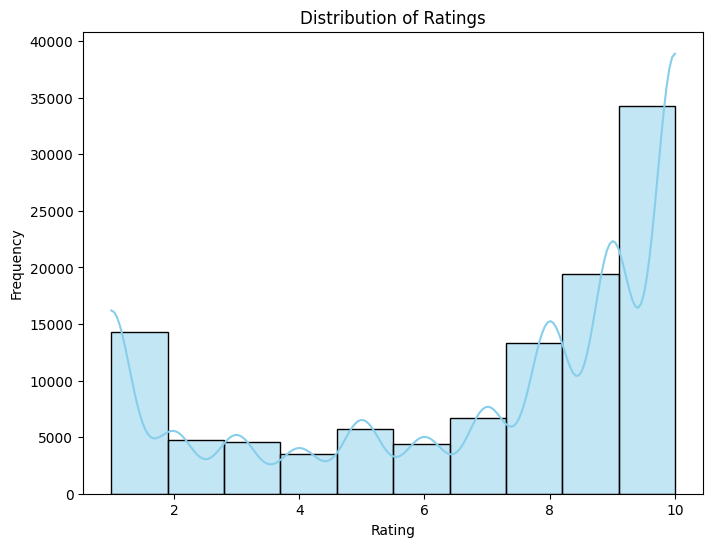

In [25]:
# Distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(train_df['rating'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Number of unique drug names
num_unique_drugs = train_df['drugName'].nunique()
print(f'Number of Unique Drug Names: {num_unique_drugs}')

Number of Unique Drug Names: 2865


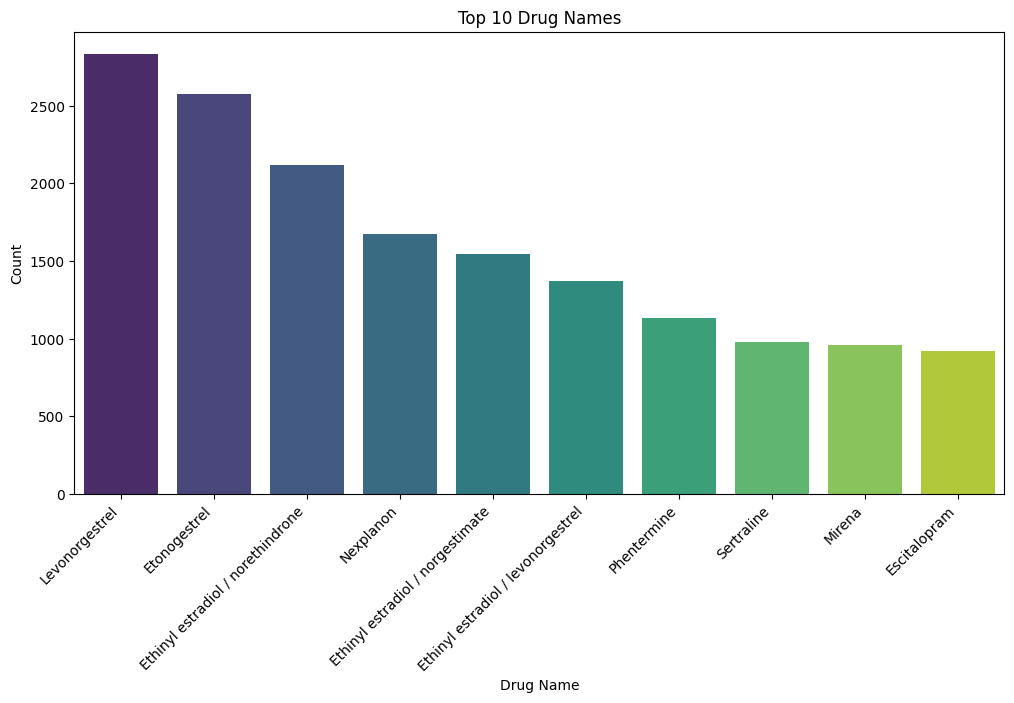

In [27]:
top_drugs = train_df['drugName'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_drugs.index, y=top_drugs.values, palette='viridis')
plt.title('Top 10 Drug Names')
plt.xlabel('Drug Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

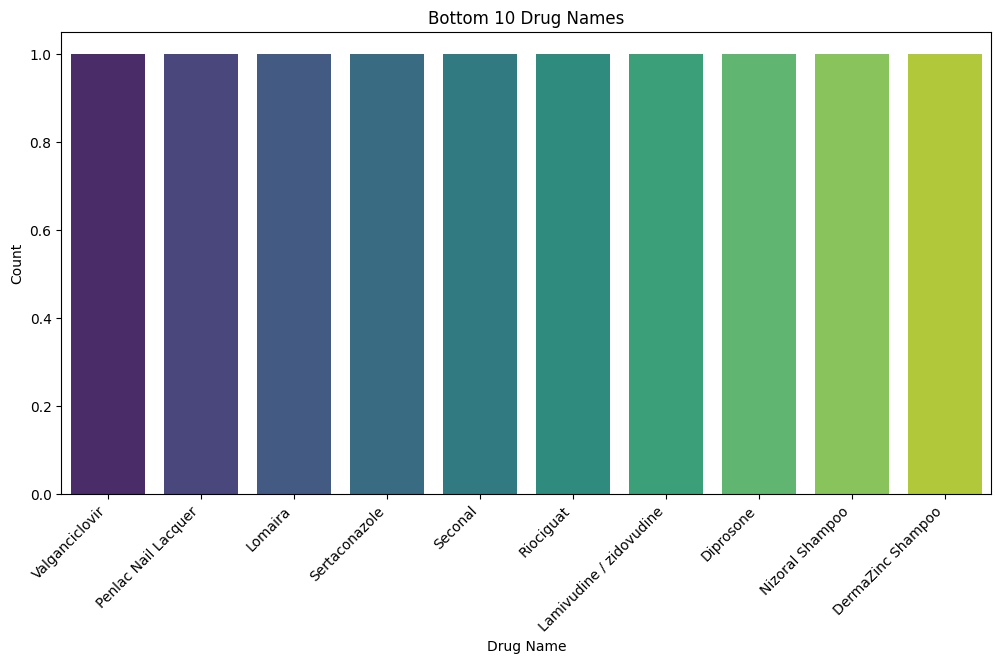

In [28]:
# Bottom 10 drug names by count
bottom_drugs = train_df['drugName'].value_counts().tail(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=bottom_drugs.index, y=bottom_drugs.values, palette='viridis')
plt.title('Bottom 10 Drug Names')
plt.xlabel('Drug Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [29]:
# Number of unique conditions
num_unique_conditions = train_df['condition'].nunique()
print(f'Number of Unique Conditions: {num_unique_conditions}')

Number of Unique Conditions: 791


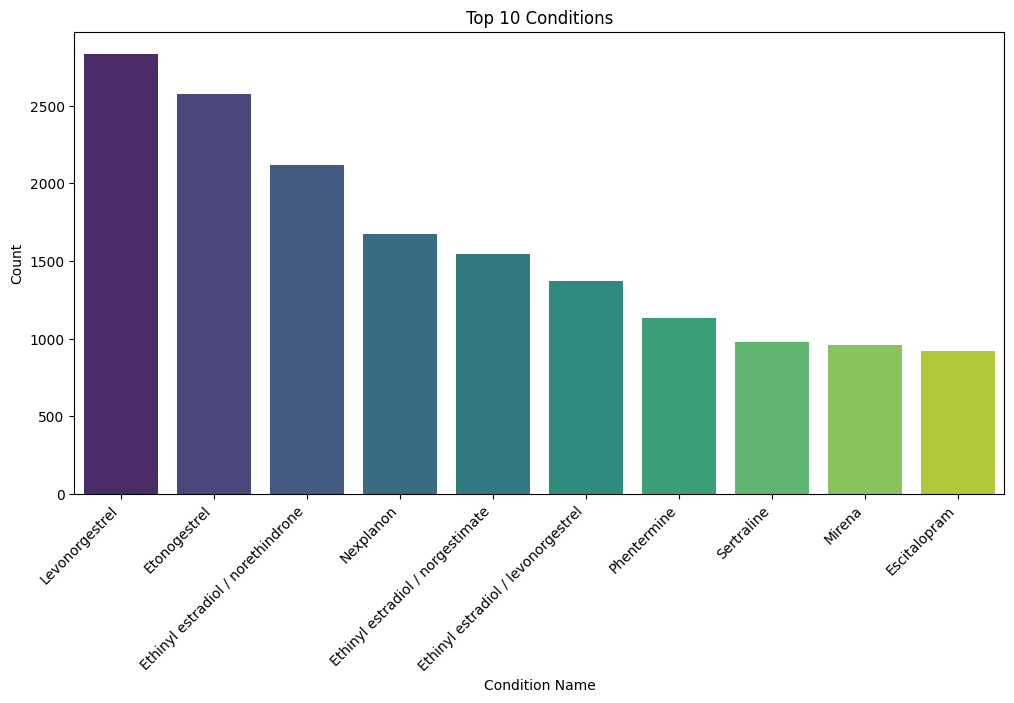

In [30]:
top_conditions = train_df['condition'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_drugs.index, y=top_drugs.values, palette='viridis')
plt.title('Top 10 Conditions')
plt.xlabel('Condition Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

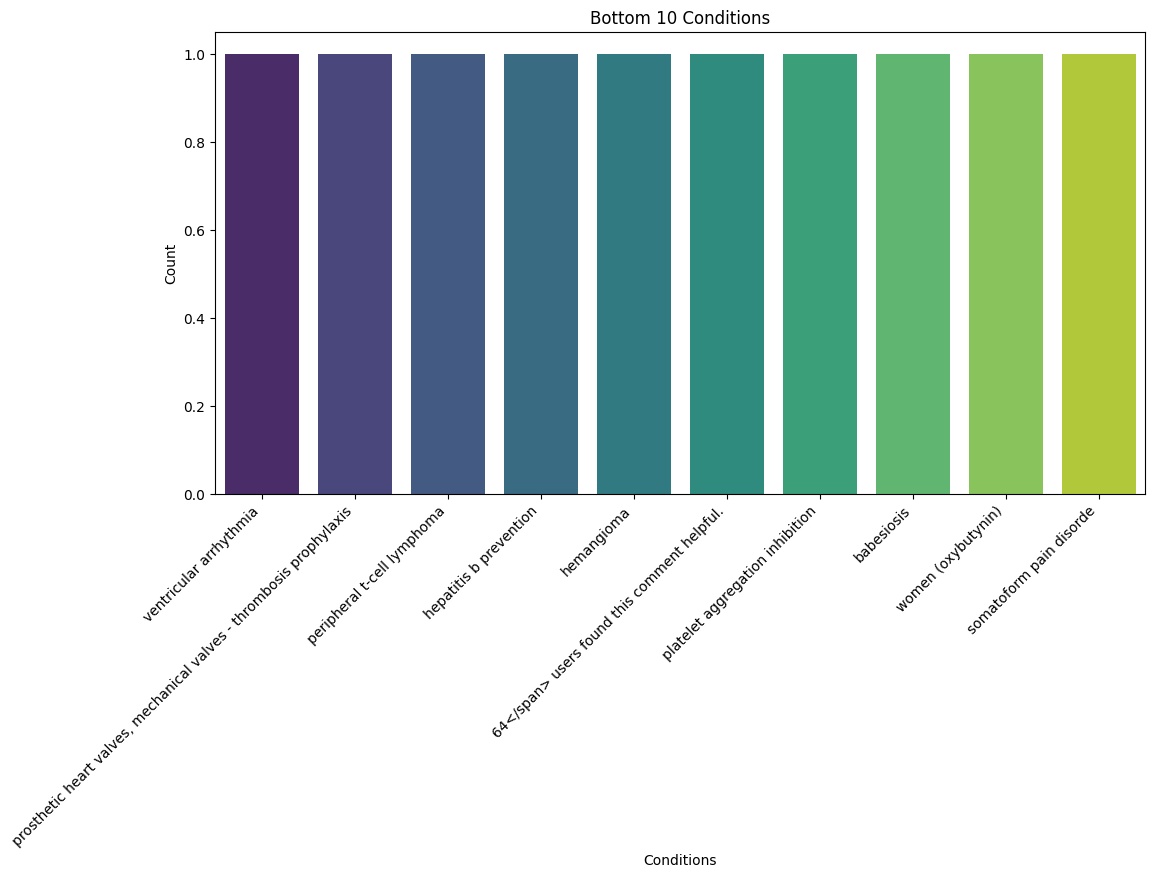

In [31]:
bottom_conditions = train_df['condition'].value_counts().tail(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=bottom_conditions.index, y=bottom_conditions.values, palette='viridis')
plt.title('Bottom 10 Conditions')
plt.xlabel('Conditions')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [32]:
# For each rating from 1 to 10, sample 5 random reviews and display them
for rating in range(1, 11):
    print(f"Rating {rating}:")
    sample_reviews = train_df[train_df['rating'] == rating]['review'].sample(n=5, random_state=42)
    for i, review in enumerate(sample_reviews):
        print(f"{i+1}. {review}")
    print("\n" + "-"*50 + "\n")

Rating 1:
1. "tried the 20 mg 10 pack free trial... tried it 5 times and saw absolutely no results... woke up every hour and a half or so the entire night.  did not feel foggy  in the morning.   with my insurance the rx would have been $90 a month. 
no thanks!"
2. " i hate the doctors that prescribe ambien  to  patients like me. they  are putting patent's life in danger.  i know some people taking this pill during the day too and they take way too much . it is adicctive"
3. "took it in 46 hours after an intercourse in which the condom tore. 4 weeks pregnant now!  cvs attendant gave this pill saying it's same as plan b. it's not!!!
spend $10 extra and get plan b! it works."
4. "i started using saxenda about a month ago - doing the increments in doses to this week at 2.4 so not quite 3 yet. first few weeks no side effects yay! then last thursday feeling nausea with extreme  ( double you over) pain so left work & hardly made it home & explosive diarrhea - left me drained, naused & sick th

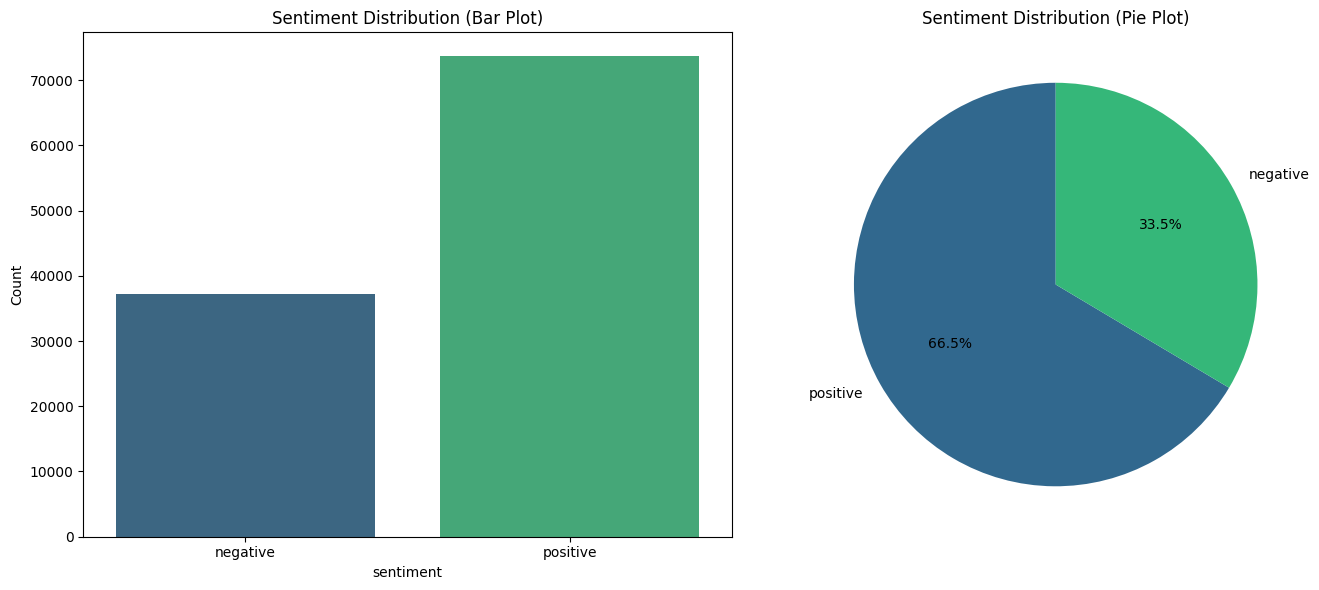

In [121]:
# Sentiment classification based on rating
train_df['sentiment'] = train_df['rating'].apply(lambda x: 'positive' if x > 6 else 'negative')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=train_df, x='sentiment', ax=axes[0], palette='viridis')
axes[0].set_title('Sentiment Distribution (Bar Plot)')
axes[0].set_ylabel('Count')

sentiment_counts = train_df['sentiment'].value_counts()
axes[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(sentiment_counts)))
axes[1].set_title('Sentiment Distribution (Pie Plot)')

plt.tight_layout()
plt.show()

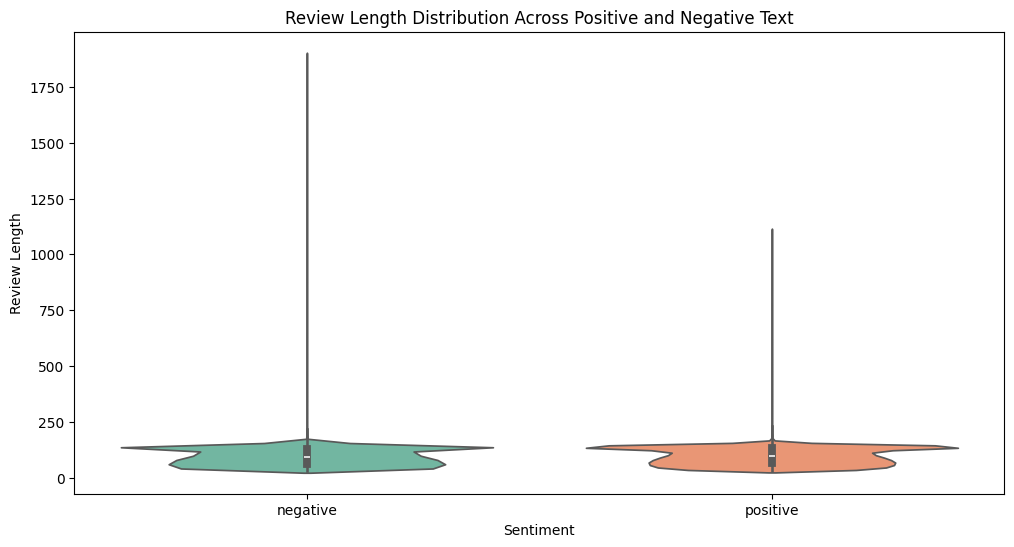

In [33]:
# Review length distribution by sentiment
plt.figure(figsize=(12, 6))
sns.violinplot(data=train_df, x='sentiment', y='review_length', palette='Set2')
plt.title('Review Length Distribution Across Positive and Negative Text')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

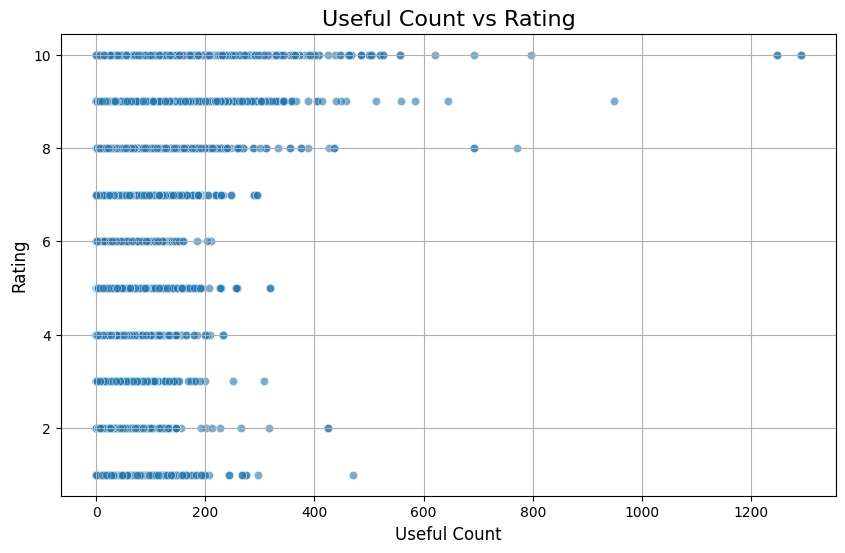

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='usefulCount', y='rating', alpha=0.6)
plt.title('Useful Count vs Rating', fontsize=16)
plt.xlabel('Useful Count', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.grid(True)
plt.show()

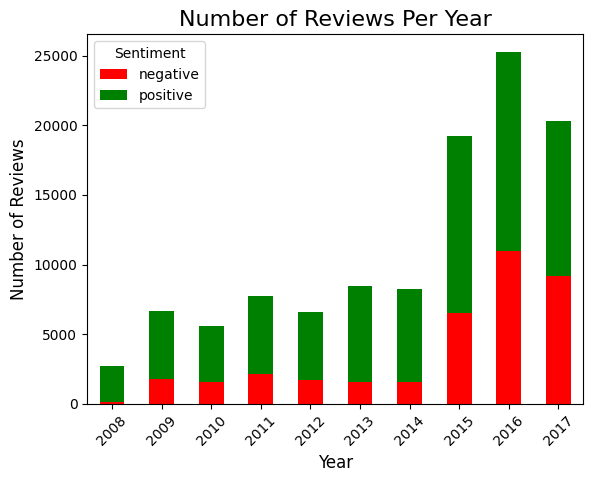

In [35]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year

sentiment_counts = train_df.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

sentiment_counts.plot(kind='bar', stacked=True, color=['red', 'green'])

plt.title('Number of Reviews Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

plt.show()

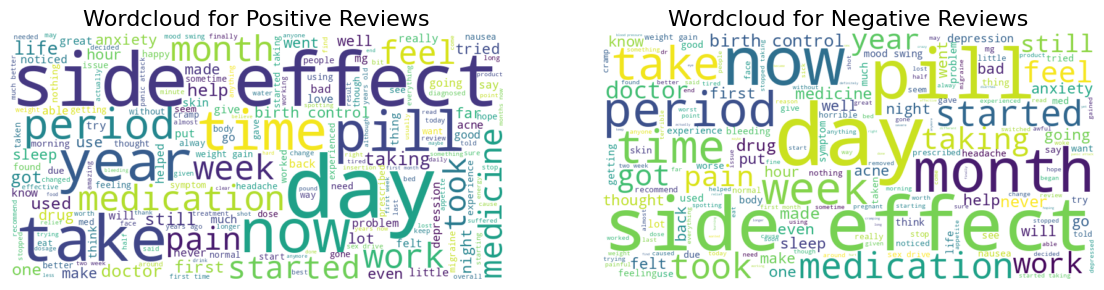

In [36]:
from wordcloud import WordCloud

# Filter for positive and negative reviews
positive_reviews = train_df[train_df['sentiment'] == 'positive']['review']
negative_reviews = train_df[train_df['sentiment'] == 'negative']['review']

# Combine reviews into one large string for each category
positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

# Generate word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(negative_text)

# Plot positive wordcloud
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Positive Reviews', fontsize=16)

# Plot negative wordcloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Negative Reviews', fontsize=16)

plt.show()


In [37]:
def find_language_codes(text):
    cleaned_text = text.replace("\n", "") 
    return detector.detect_language_of(text)

tqdm.pandas(desc="Detecting language codes")
train_df["language_code"] = train_df["review"].progress_apply(find_language_codes)
train_df.head(3)

Detecting language codes: 100%|██████████| 110811/110811 [02:10<00:00, 850.77it/s]


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,2013-04-20,69,147,negative,2013,Language.ENGLISH
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,2016-08-07,4,136,positive,2016,Language.ENGLISH
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,2016-05-11,6,140,negative,2016,Language.ENGLISH


In [38]:
for i in train_df[train_df['language_code'] != Language.ENGLISH]['review']:
    print(i, end="\n\n")

"do not allow dr to put you on this medication if you:
are autoimmune (positive ana, rheumatoid arthritis, systemic lupus, sjögren's syndrome)
or take: 
effexor or any other snri
i am experiencing liver injury due to the combination of these conditions/drugs"

"the miracle pill!
i have constipation since my childhood.
i have try everything on the market and even change my diet with high fiber with no result. i am 53 years old and for the first time of my life ,i am regular(go every day).
i feel like a new person.i use to go once a week .constella pill just change my life!
la pilule miracle.je souffre de constipation depuis mon enfance.j'ai tout essayé sur le marché et même avec un régime à haute teneur en fibre,aucun resultat.j'ai 53 ans et pour la première fois de toute ma vie,je suis régulière(une fois tout les jour plutôt qu'une fois par semaine!)
je suis une nouvelle personne. constella a changé ma vie!"

"i was using it by a trial, for a year and im in love. my skin was clear like

In [39]:
tqdm.pandas()

def count_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    urls = re.findall(url_pattern, text)
    return len(urls)

train_df['num_urls'] = train_df['review'].progress_apply(count_urls)
print(train_df[train_df['num_urls'] > 0].shape)
display(train_df[train_df['num_urls'] > 0].head(3))

100%|██████████| 110811/110811 [00:00<00:00, 160907.38it/s]

(18, 12)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls
18,148611,Mirena,birth control,"""i love my iud for many reasons. a lot of thes...",10.0,2017-02-08,40,134,positive,2017,Language.ENGLISH,1
665,200028,Varenicline,smoking cessation,"""i took a 2 week short course with champix as ...",9.0,2015-11-01,10,121,positive,2015,Language.ENGLISH,1
5164,76520,Quazepam,not listed / othe,"""i took doral for years for meniere's until it...",9.0,2016-05-19,8,41,positive,2016,Language.ENGLISH,1


In [40]:
train_df[train_df['num_urls'] > 0].iloc[3, 3]

'"i was in the original fda fk506 study as a pre-transplant patient (primary sclerosing cholangitis ).  i had been given 6 yrs to have a liver transplant.  my liver #\'s were 3-4 digits and i was becoming very ill.  my dosage was stabilized at 3 mgs and my numbers have decreased to normal.  i have been on this medicine since 10 \'92 and still no transplant.  the medicine has slowed the progress of psc drastically.  i see it is used for crohn\'s, but nothing is listed for liver diseases.  did they ever evaluate the trial results from the early 90\'s?   my current insurance will not approve the drug for me for this reason.  this might be the result of the trial www.ncbi.nlm.nih.gov/pmc/articles/pmc2982698/ or is a similar one."'

In [41]:
def count_user_mentions(text):
    user_pattern = r'@\w+'
    mentions = re.findall(user_pattern, text)
    return len(mentions)

train_df['count_user_mentions'] = train_df['review'].progress_apply(count_user_mentions)
print(train_df[train_df['count_user_mentions'] > 0].shape)
display(train_df[train_df['count_user_mentions'] > 0].head(3))

100%|██████████| 110811/110811 [00:00<00:00, 586734.17it/s]

(63, 13)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions
329,87796,Naproxen,muscle pain,"""i have taken l x aleve 500 every morning for ...",10.0,2009-05-15,26,67,positive,2009,Language.ENGLISH,0,1
1331,178745,Victoza,"diabetes, type 2","""i started taking victoza february 2015 @the s...",8.0,2015-10-27,23,137,positive,2015,Language.ENGLISH,0,1
2836,126179,Viibryd,depression,"""my doc gave me a titration pack of viibryd an...",7.0,2012-05-22,15,144,positive,2012,Language.ENGLISH,0,1


In [42]:
train_df[train_df['count_user_mentions'] > 0].iloc[3, 3]

'"i have bipolar disorder and generalized anxiety. i take bupropion daily and xanax (0.5-1 mg as needed) usually twice a day. i started 3 days ago on 5mg olanzapine (@bedtime) .  wow.  noticed much more stable mood on day 1.  today is day 3 and again, very stable mood and sleeping through the night since starting and am very happy with these results so far.  i have not had a need for xanax since starting. the only side effect i am experiencing so far is fatigue in the morning hours - no change in appetite or other effects mentioned by others in this column.  i will post again in a few months to update my results.  "'

In [43]:
def has_numbers(text):
    number_pattern = r'\b\d+([.,]\d+)*\b'
    return bool(re.search(number_pattern, text))

train_df['has_numbers'] = train_df['review'].progress_apply(has_numbers)
print(train_df[train_df['has_numbers'] > 0].shape)
display(train_df[train_df['has_numbers'] > 0].head(3))

100%|██████████| 110811/110811 [00:00<00:00, 159813.32it/s]


(83858, 14)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions,has_numbers
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,2013-04-20,69,147,negative,2013,Language.ENGLISH,0,0,True
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,2016-08-07,4,136,positive,2016,Language.ENGLISH,0,0,True
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,2016-05-11,6,140,negative,2016,Language.ENGLISH,0,0,True


In [44]:
train_df[train_df['has_numbers'] > 0].iloc[3, 3]

'"i recommend taking as prescribed, and the bottle usually says "take x amount every x hours". i think that having a steady stream of any medication is the only way to have it work. this medication\'s only side effect i have found is almost exactly like when one takes benadryl, and only when you are first starting out on it. i am used to it now after 3 weeks and the only effect i notice is that my hands no longer shake and my mind is at ease. much better and smoother than other meds like xanax or tramadol or klonopin, etc., etc. "'

In [45]:
def count_hashtags(text):
    hashtag_pattern = r'#\S+'
    hashtags = re.findall(hashtag_pattern, text)
    return len(hashtags)

train_df['count_hashtags'] = train_df['review'].progress_apply(count_hashtags)
print(train_df[train_df['count_hashtags'] > 0].shape)
display(train_df[train_df['count_hashtags'] > 0].head(3))

100%|██████████| 110811/110811 [00:00<00:00, 601480.77it/s]

(319, 15)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions,has_numbers,count_hashtags
337,131103,Altavera,birth control,"""#1 it gave me acne. #2 i gained so much weigh...",1.0,2015-12-30,4,61,negative,2015,Language.ENGLISH,0,0,True,3
862,220288,Amitriptyline,migraine prevention,"""i had daily migraines for several years. i ha...",9.0,2012-06-18,32,124,positive,2012,Language.ENGLISH,0,0,True,1
922,211161,Aftera,emergency contraception,"""sunday i had unprotected sex, wasn't sure if ...",10.0,2016-03-29,13,117,positive,2016,Language.ENGLISH,0,0,True,1


In [46]:
train_df[train_df['count_hashtags'] > 0].iloc[3, 3]

'"i\'ve had cold sores since i was a child. it\'s embarrassing and ghastly to look at. i\'m now 32 and i\'ve figured out the best remedies to prevent or speed up healing time. \r\r\nthe #1 best medication is l-lysine. i take 1000 mg capsules (nature\'s bounty) at the first sign of an itch, tingle or irritation. i take no chances! since taking l-lysine i haven\'t had one form yet. dry lips on windy days, runny nose and stress are my triggers. \r\r\n#2 is ice.  freezing it prevents the blisters from forming. the virus thrives in warm, moist areas. use #3 rubbing alcohol w/ ice to dry out sore. for those naturopaths, #4 turmeric is great in stopping blisters from spreading. it\'s a natural anti-inflammatory and the virus is unable to thrive. best of luck!!!"'

In [47]:
def count_elongated_words(text):
    elongated_pattern = r'\b(\S*?)(.)\2{2,}\b'
    elongated_words = re.findall(elongated_pattern, text)
    return len(elongated_words)

train_df['count_elongated_words'] = train_df['review'].progress_apply(count_elongated_words)
print(train_df[train_df['count_elongated_words'] > 0].shape)
display(train_df[train_df['count_elongated_words'] > 0].head(3))

100%|██████████| 110811/110811 [00:05<00:00, 21822.50it/s]

(8490, 16)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions,has_numbers,count_hashtags,count_elongated_words
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,2016-08-07,4,136,positive,2016,Language.ENGLISH,0,0,True,0,1
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,2016-05-11,6,140,negative,2016,Language.ENGLISH,0,0,True,0,3
18,148611,Mirena,birth control,"""i love my iud for many reasons. a lot of thes...",10.0,2017-02-08,40,134,positive,2017,Language.ENGLISH,1,0,True,0,1


In [48]:
train_df[train_df['count_elongated_words'] > 0].iloc[2, 3]

'"i love my iud for many reasons. a lot of these reviews are just based off of the initial side effects and insertion. while i admit it was mildly painful for the first 24 hours and the spotting lasted 1-2 months, i am now 3 years in, and couldn\'t be happier. my period is 95% lighter and lasts only an hour, i never get cramps anymore, and i am comforted by the fact that it is so reliable! no weight gain or mood changes and my skin is still clear. some people say these cause infertility but that is not true. iuds have undergone many many clinical studies which show that is not the case! don\'t let people on here scare you :) if you want the facts, go to a credible source. http://www.sciencedirect.com/science/article/pii/0010782485900484"'

In [49]:
def check_emoticons(text):
    emoticon_count = 0
    for emoticon in EMOTICONS_EMO:
        if emoticon in text:
            emoticon_count += 1
    return emoticon_count

train_df['num_emoticons'] = train_df['review'].progress_apply(check_emoticons)
print(train_df[train_df['num_emoticons'] > 0].shape)
display(train_df[train_df['num_emoticons'] > 0].head(3))

100%|██████████| 110811/110811 [00:08<00:00, 12689.45it/s]


(2903, 17)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions,has_numbers,count_hashtags,count_elongated_words,num_emoticons
18,148611,Mirena,birth control,"""i love my iud for many reasons. a lot of thes...",10.0,2017-02-08,40,134,positive,2017,Language.ENGLISH,1,0,True,0,1,2
25,98205,Nexplanon,birth control,"""absolutely hate it had it put in in nov 2014 ...",1.0,2015-06-29,9,149,negative,2015,Language.ENGLISH,0,0,True,0,0,1
80,39990,Contrave,obesity,"""made it up to the 4 a day dose. unfortunately...",3.0,2015-07-07,15,90,negative,2015,Language.ENGLISH,0,0,True,0,0,1


In [50]:
train_df[train_df['num_emoticons'] > 0].iloc[1, 3]

'"absolutely hate it had it put in in nov 2014 and by march 2015 i was 85 pounds heavier .i had bad breakouts to the point they became open sores. i was retaining water like crazy and my hair is falling out to the point that i have a patch on the back of my head about 2inx 1inch that is completely bald and smooth like it won\'t grow back in. just got it cut out today and was told that it could take another 9 months for my hair to. start growing back in. also so irregular with periods i would never know when to carry tampons with me and the one time i don\'t it comes full force.do not get this unless you want to go from a size 8-10 pants to an 18w... :( hoping the weight comes off so i can go back to normal)"'

In [51]:
def count_emojis(text):
    emoji_count = 0
    for emoji_shortcode in EMOJI_UNICODE:
        if emoji_shortcode in text:
            emoji_count += text.count(emoji_shortcode)
    return emoji_count

train_df['num_emojis'] = train_df['review'].progress_apply(count_emojis)
print(train_df[train_df['num_emojis'] > 0].shape)
display(train_df[train_df['num_emojis'] > 0].head(3))

100%|██████████| 110811/110811 [01:26<00:00, 1285.15it/s]

(0, 18)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions,has_numbers,count_hashtags,count_elongated_words,num_emoticons,num_emojis


## Data Preprocessing

As described here: https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

- remove non english words
- remove escape characters and @
- URLs → <URL> Detects and replaces links like https://example.com with <URL>.
- Numbers → <NUMBER> Replaces numbers, including decimals and comma-separated values (1,000.5 → <NUMBER>).
- Punctuation Repetitions → <REPEAT> "!!???" → "! <REPEAT>"

In [52]:
def fix_negation(sentence):
    synsets_cache = {}

    def get_first_synset(word):
        if word not in synsets_cache:
            synsets = wordnet.synsets(word)
            synsets_cache[word] = synsets[0] if synsets else None
        return synsets_cache[word]

    for i in range(1, len(sentence)): 
        if sentence[i-1] in ['not', "n't"]:
            antonyms = []
            word_synset = get_first_synset(sentence[i])
            if word_synset:
                for lemma in word_synset.lemmas():
                    if lemma.antonyms():
                        antonym_name = lemma.antonyms()[0].name()
                        antonyms.append(antonym_name)
                        break

                if antonyms:
                    antonym_synset = get_first_synset(antonyms[0])
                    if antonym_synset:
                        sentence[i] = antonyms[0]
                        sentence[i-1] = ''

    sentence = [word for word in sentence if word]

    return sentence


def convert_emoticons(text):
    for emote in EMOTICONS_EMO:
        escaped_emote = re.escape(emote)
        text = re.sub(u'('+escaped_emote+')', "_".join(EMOTICONS_EMO[emote].replace(",","").split()), text)
    return text

In [53]:
def preprocess_text(text):
    # Step 1: Convert emoticons
    sentence = convert_emoticons(text)
    
    # Step 2: Fix negations
    sentence = sentence.lower().split()
    sentence = fix_negation(sentence)
    sentence = " ".join(sentence)

    # Step 3: Remove escape characters, # and @ symbols
    sentence = re.sub(r'\\', '', sentence)  # Remove escape characters
    sentence = re.sub(r'[@#]', '', sentence)  # Remove @ and # symbols
    sentence = sentence.replace('"', '')

    # Step 4: Replace URLs, numbers, and punctuation repetitions
    sentence = re.sub(r'https?://\S+|www\.\S+', '<URL>', sentence)  # Replace URLs with <URL>
    sentence = re.sub(r'\d+([.,]\d+)?', '<NUMBER>', sentence)  # Replace numbers
    sentence = re.sub(r'([!?.])\1{2,}', r'\1 <REPEAT>', sentence)  # Replace punctuation repetitions

    return sentence

In [54]:
tqdm.pandas(desc="Preprocessing reviews")
train_df['processed_review'] = train_df['review'].progress_apply(lambda x: preprocess_text(x))

train_df = train_df[train_df['language_code'] == Language.ENGLISH]

# Show the processed data
train_df[['review', 'processed_review', 'sentiment']].head()

Preprocessing reviews: 100%|██████████| 110811/110811 [01:02<00:00, 1765.54it/s]


,review,processed_review,sentiment
0,"""i have used restasis for about a year now and...",i have used restasis for about a year now and ...,negative
1,"""my experience has been somewhat mixed. i have...",my experience has been somewhat mixed. i have ...,positive
2,"""this is my second implanon would not recommen...",this is my second implanon would not recommend...,negative
3,"""i recommend taking as prescribed, and the bot...","i recommend taking as prescribed, and the bott...",positive
4,"""i have been on ampyra for 5 days and have bee...",i have been on ampyra for <NUMBER> days and ha...,positive


In [55]:
print(train_df[['review', 'processed_review', 'sentiment']].iloc[0, 1])

i have used restasis for about a year now and have seen almost no progress. for most of my life i've had red and bothersome eyes. after trying various eye drops, my doctor recommended restasis. he said it typically takes <NUMBER> to <NUMBER> months for it to really kick in but it never did kick in. when i put the drops in it burns my eyes for the first <NUMBER> - <NUMBER> minutes. i've talked with my doctor about this and he said it is normal but should go away after some time, but it hasn't. every year around spring time my eyes get terrible irritated and this year has been the same (maybe even worse than other years) even though i've been using restasis for a year now. the only difference i notice was for the first couple weeks, but now i'm ready to move on.


## Text Embedding Generation

In [90]:
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)

In [91]:
def prepare_data(train_df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df['processed_review'])
    sequences = tokenizer.texts_to_sequences(train_df['processed_review'])
    max_sequence_length = 300
    X = pad_sequences(sequences, maxlen=max_sequence_length)
    return X, tokenizer

def transform_data(data, tokenizer):
    sequences = tokenizer.texts_to_sequences(data['processed_review'])
    max_sequence_length = 300
    X = pad_sequences(sequences, maxlen=max_sequence_length)
    return X

In [92]:
X_train, tokenizer = prepare_data(train_data)
X_valid = transform_data(valid_data, tokenizer)

In [93]:
def prepare_glove_embeddings(tokenizer, glove_file, embedding_dim=300):
    embeddings_index = load_glove_embeddings(glove_file, embedding_dim)
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, index in tqdm(tokenizer.word_index.items()):
        if word in embeddings_index:
            embedding_matrix[index] = embeddings_index[word]
        else:
            embedding_matrix[index] = np.random.normal(size=(embedding_dim,))
    return embedding_matrix, vocab_size

In [94]:
# Load GloVe embeddings
def load_glove_embeddings(glove_file, embedding_dim=300):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [95]:
# !wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
# !unzip glove.6B.zip

In [96]:
embedding_matrix, vocab_size = prepare_glove_embeddings(tokenizer, 'glove.6B.300d.txt')

100%|██████████| 41244/41244 [00:00<00:00, 155037.88it/s]


## Modelling

In [125]:
def build_model(vocab_size, embedding_matrix, max_sequence_length, embedding_dim=300):
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_sequence_length,
                  trainable=False),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.5),
        LSTM(32),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [126]:
model = build_model(vocab_size, embedding_matrix, max_sequence_length=300)

In [127]:
sentiment_dict = {'negative': 0, 'positive': 1}
y_train = train_data['sentiment'].map(sentiment_dict).values

X_valid = transform_data(valid_data, tokenizer)
y_valid = valid_data['sentiment'].map(sentiment_dict).values
y_train[:5], y_valid[:5]

(array([1, 0, 0, 1, 0]), array([1, 1, 0, 1, 1]))

In [128]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 1.4902494788514558, 1: 0.7524616324867581}

In [129]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,         
                               restore_best_weights=True,
                               verbose=1)


history = model.fit(X_train, y_train, 
                    epochs=25, 
                    batch_size=64, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping],
                    class_weight=class_weight_dict)

Epoch 1/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 35ms/step - accuracy: 0.6841 - loss: 0.5856 - val_accuracy: 0.8147 - val_loss: 0.4125
Epoch 2/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.7989 - loss: 0.4391 - val_accuracy: 0.8248 - val_loss: 0.3833
Epoch 3/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.8347 - loss: 0.3775 - val_accuracy: 0.8321 - val_loss: 0.3893
Epoch 4/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.8596 - loss: 0.3313 - val_accuracy: 0.8331 - val_loss: 0.3706
Epoch 5/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.8758 - loss: 0.2978 - val_accuracy: 0.8636 - val_loss: 0.3190
Epoch 6/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.8917 - loss: 0.2647 - val_accuracy: 0.8705 - val_loss: 0.3161
Epoch 7/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.9057 - loss: 0.2349 - val_accuracy: 0.8609 - val_loss: 0.3374
Epoch 8/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.9166 -

In [130]:
def plot_training_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    train_acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

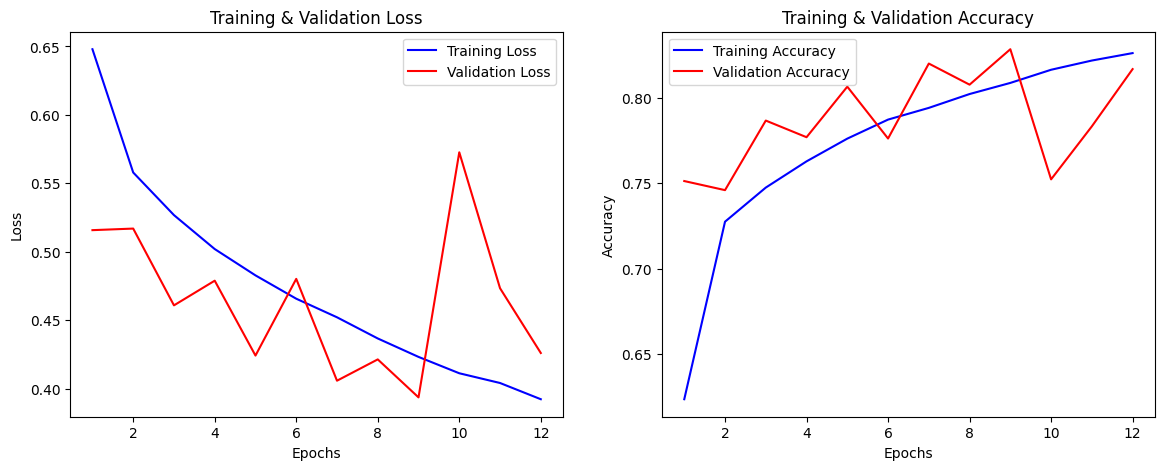

In [138]:
%matplotlib inline
plot_training_curves(history)

In [134]:
from keras.layers import BatchNormalization

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=300,
              weights=[embedding_matrix],
              input_length=300,
              trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [136]:
from keras.optimizers import AdamW

optimizer = AdamW(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [137]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,         
                               restore_best_weights=True,
                               verbose=1)


history = model.fit(X_train, y_train, 
                    epochs=25, 
                    batch_size=64, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping],
                    class_weight=class_weight_dict)

Epoch 1/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 0.5688 - loss: 0.6914 - val_accuracy: 0.7512 - val_loss: 0.5158
Epoch 2/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.7215 - loss: 0.5665 - val_accuracy: 0.7459 - val_loss: 0.5169
Epoch 3/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.7449 - loss: 0.5317 - val_accuracy: 0.7867 - val_loss: 0.4608
Epoch 4/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 50s 36ms/step - accuracy: 0.7603 - loss: 0.5069 - val_accuracy: 0.7769 - val_loss: 0.4788
Epoch 5/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.7740 - loss: 0.4851 - val_accuracy: 0.8065 - val_loss: 0.4241
Epoch 6/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.7870 - loss: 0.4646 - val_accuracy: 0.7761 - val_loss: 0.4802
Epoch 7/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.7938 - loss: 0.4509 - val_accuracy: 0.8201 - val_loss: 0.4058
Epoch 8/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 36ms/step - accuracy: 0.8026 -

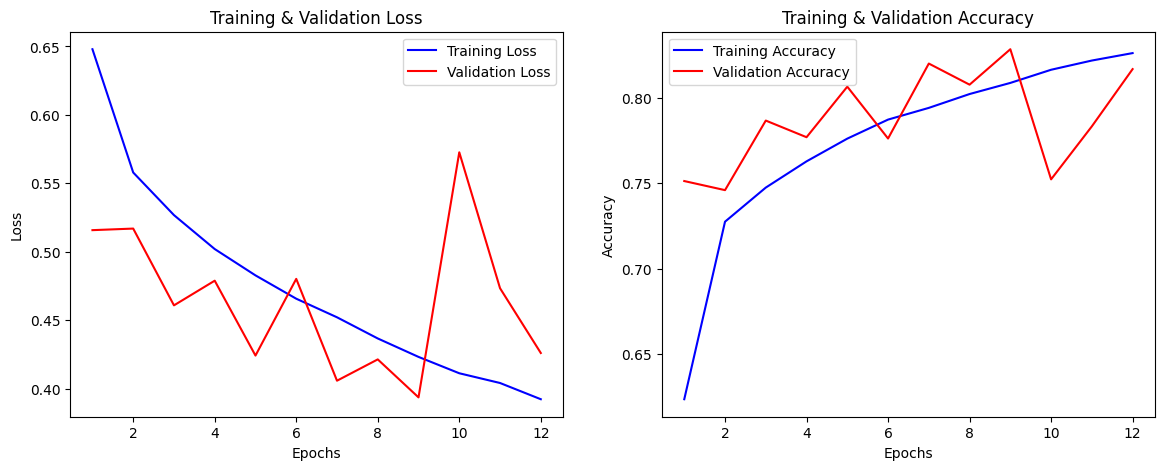

In [139]:
%matplotlib inline
plot_training_curves(history)

## Evaluation

In [140]:
test_df.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,163740,Mirtazapine,depression,"""i've tried a few antidepressants over the yea...",10.0,"February 28, 2012",22,68
1,206473,Mesalamine,"crohn's disease, maintenance","""my son has crohn's disease and has done very ...",8.0,"May 17, 2009",17,48
2,39293,Contrave,weight loss,"""contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,143
3,97768,Cyclafem 1 / 35,birth control,"""i have been on this birth control for one cyc...",9.0,"October 22, 2015",4,149
4,208087,Zyclara,keratosis,"""4 days in on first 2 weeks. using on arms an...",4.0,"July 3, 2014",13,60


In [141]:
test_df['sentiment'] = test_df['rating'].apply(lambda x: 'positive' if x > 6 else 'negative')

In [142]:
tqdm.pandas(desc="Preprocessing reviews")
test_df['processed_review'] = test_df['review'].progress_apply(lambda x: preprocess_text(x))

tqdm.pandas(desc="Detecting language codes")
test_df["language_code"] = test_df["review"].progress_apply(find_language_codes)

test_df = test_df[test_df['language_code'] == Language.ENGLISH]
test_df[['review', 'processed_review', 'sentiment']].head()

Detecting language codes: 100%|██████████| 46108/46108 [00:56<00:00, 818.13it/s]


,review,processed_review,sentiment
0,"""i've tried a few antidepressants over the yea...",i've tried a few antidepressants over the year...,positive
1,"""my son has crohn's disease and has done very ...",my son has crohn's disease and has done very w...,positive
2,"""contrave combines drugs that were used for al...",contrave combines drugs that were used for alc...,positive
3,"""i have been on this birth control for one cyc...",i have been on this birth control for one cycl...,positive
4,"""4 days in on first 2 weeks. using on arms an...",<NUMBER> days in on first <NUMBER> weeks. usin...,negative


In [143]:
X_test = transform_data(test_df, tokenizer)
y_test = test_df['sentiment'].map(sentiment_dict).values

In [146]:
from sklearn.metrics import confusion_matrix, classification_report
from pprint import pprint

y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(int)

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step


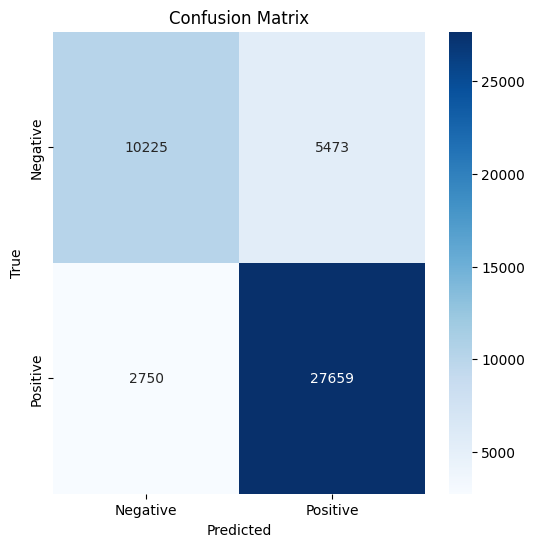

In [147]:
# Step 3: Get the confusion matrix
cm = confusion_matrix(y_test, y_pred_bin)

# Step 4: Display the confusion matrix as a heatmap
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [149]:
report = classification_report(y_test, y_pred_bin, target_names=['Negative', 'Positive'])
pprint(report)

('              precision    recall  f1-score   support\n'
 '\n'
 '    Negative       0.79      0.65      0.71     15698\n'
 '    Positive       0.83      0.91      0.87     30409\n'
 '\n'
 '    accuracy                           0.82     46107\n'
 '   macro avg       0.81      0.78      0.79     46107\n'
 'weighted avg       0.82      0.82      0.82     46107\n')


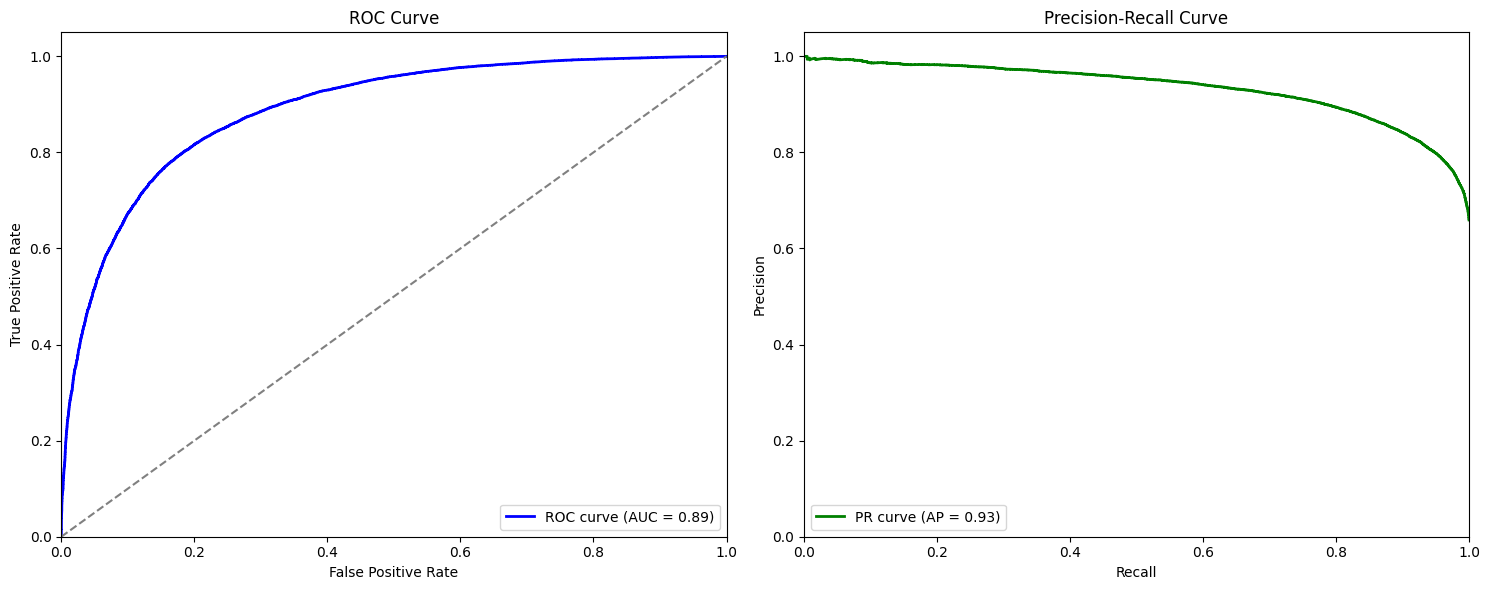

In [154]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--') 
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')

# Precision-Recall Curve
ax2.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc='lower left')

# Show the plot
plt.tight_layout()
plt.show()